In [1]:
import tensorflow
import matplotlib.pyplot as pyplot
from tensorflow import keras
import pathlib
from tensorflow import io
from tensorflow.data import Dataset 
from colorama import Fore
import numpy
from tqdm import tqdm
import time
import os
from IPython import display

In [4]:
# Initialize TensorBoard writer 
log_dir = "logs/gan" 
summary_writer = tensorflow.summary.create_file_writer(log_dir)

In [5]:
### hyperparameter
batch_size = 256
epochs = 1330
noise_dim = 100
image_size = 64
dataset_path = './dataset'
progress_folder = "./progress"
model_folder = "./models"
num_examples_to_generate = 16
seed = tensorflow.random.normal([num_examples_to_generate, noise_dim])

In [4]:
### create a folder if it does not exist
def create_folder(path):
    """
    If a folder does not exist then create one
    """
    
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
### initial folders
create_folder(dataset_path)
create_folder(progress_folder)
create_folder(model_folder)

In [6]:
### get image paths
dataset_directory = pathlib.Path(dataset_path)
image_paths = list(dataset_directory.glob('cats/*.jpg'))
image_paths = list(map(lambda x: str(x), image_paths))

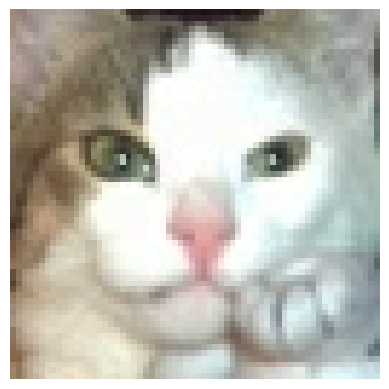

In [7]:
### display an image
image = io.read_file(image_paths[3])
image = io.decode_image(image)
pyplot.axis(False)
pyplot.imshow(image)

In [8]:
### function to decode image and transform pixel to range (0, 1)
def decode_image(image_path):
    image = io.read_file(image_path)
    image = io.decode_image(image, channels=3, expand_animations=False)
    image = tensorflow.image.resize(image, [image_size, image_size])
    image = image / 255
    image = tensorflow.cast(image, tensorflow.float32)
    return image

In [9]:
### load image from path and push it to dataset
train_dataset = Dataset.from_tensor_slices(image_paths)
train_dataset = train_dataset.map(decode_image, num_parallel_calls=tensorflow.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
train_dataset = train_dataset.prefetch(tensorflow.data.AUTOTUNE)
train_dataset = train_dataset.cache()

In [10]:
### info about dataset
# Get the number of batches
num_batches = tensorflow.data.experimental.cardinality(train_dataset).numpy()

# Calculate total number of elements in the train dataset
total_elements_in_train = sum(1 for _ in train_dataset.unbatch())

# # Calculate total number of elements in the train dataset
# total_elements_in_validation = sum(1 for _ in validation_dataset.unbatch())

# print out the number of batches
print(Fore.GREEN + '### number of batches: ' + Fore.RESET, end="")
print(num_batches)

# print out the number of items in the dataset
print(Fore.GREEN + '### number of items in train dataset: ' + Fore.RESET, end="")
print(total_elements_in_train)

# # print out the number of items in the dataset
# print(Fore.GREEN + '### number of items in validation dataset: ' + Fore.RESET, end="")
# pprint(total_elements_in_validation)

### number of batches: 62
### number of items in train dataset: 15747


In [11]:
FILTER_COUNT = 16
IN_LAYER_COUNT = 6
DISC_FILTER_COUNT = FILTER_COUNT

In [12]:
### build generator
def build_generator():
    model = keras.Sequential()
    model.add(keras.layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 64, 64, 3)
    
    
    # model.add(keras.layers.Dense(
    #     (image_size//(2**IN_LAYER_COUNT))*(image_size//(2**IN_LAYER_COUNT))*noise_dim, use_bias=False, input_shape=(noise_dim,)))
    # model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.LeakyReLU())

    # model.add(keras.layers.Reshape((image_size//(2**IN_LAYER_COUNT),
    #           image_size//(2**IN_LAYER_COUNT), noise_dim)))

    # for i in range(IN_LAYER_COUNT):
    #     model.add(keras.layers.Conv2DTranspose(FILTER_COUNT*2**(IN_LAYER_COUNT-i-1),
    #               (6, 6), strides=(2, 2), padding='same', use_bias=False))
    #     model.add(keras.layers.BatchNormalization())
    #     model.add(keras.layers.LeakyReLU())

    # model.add(keras.layers.Conv2DTranspose(3, (6, 6), strides=(1, 1),
    #                                  padding='same', use_bias=False, activation='sigmoid'))
    # assert model.output_shape == (None, image_size, image_size, 3)


    return model

In [13]:
### build discriminator
def build_discriminator():
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    
    # model.add(keras.layers.Conv2D(DISC_FILTER_COUNT, (6, 6), strides=(2, 2), padding='same',
    #                                  input_shape=[image_size, image_size, 3]))
    # model.add(keras.layers.LeakyReLU())
    # model.add(keras.layers.Dropout(0.3))

    # for i in range(1, IN_LAYER_COUNT):
    #     model.add(keras.layers.Conv2D(DISC_FILTER_COUNT*(2**i), (6, 6), strides=(2, 2), padding='same'))
    #     model.add(keras.layers.LeakyReLU())
    #     model.add(keras.layers.Dropout(0.3))

    # model.add(keras.layers.Flatten())
    # model.add(keras.layers.Dense(1,activation='sigmoid'))


    return model

In [14]:
generator = build_generator()
discriminator = build_discriminator()

In [15]:
### declare cross entropy loss
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits = True)

In [16]:
### Generator loss
def generator_loss(random_image):
  return cross_entropy(tensorflow.ones_like(random_image), random_image)

In [17]:
### Discriminator loss
def discriminator_loss(real_image, random_image):
  real_image_loss = cross_entropy(tensorflow.ones_like(real_image), real_image)
  random_image_loss = cross_entropy(tensorflow.zeros_like(random_image), random_image)
  return real_image_loss + random_image_loss

In [18]:
### plot loss
def plot_losses(gen_losses, disc_losses):
    pyplot.plot(gen_losses, label='Generator')
    pyplot.plot(disc_losses, label='Discriminator')
    pyplot.legend()
    pyplot.show()

In [19]:
### display pixel image
def display_pixel_image(grid_size, image):
    grid_size = grid_size
    colors = image
    
    pyplot.figure(figsize=(10, 10))
    pyplot.imshow(colors, extent=[0, grid_size, 0, grid_size])
    pyplot.xticks(numpy.arange(0, grid_size, 1), labels=[])
    pyplot.yticks(numpy.arange(0, grid_size, 1), labels=[])
    pyplot.grid(which="both", color="black", linewidth=0.5)
    pyplot.show()

In [20]:
# Optimizers
generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

In [21]:
### checkpoint
checkpoint_dir = './models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tensorflow.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

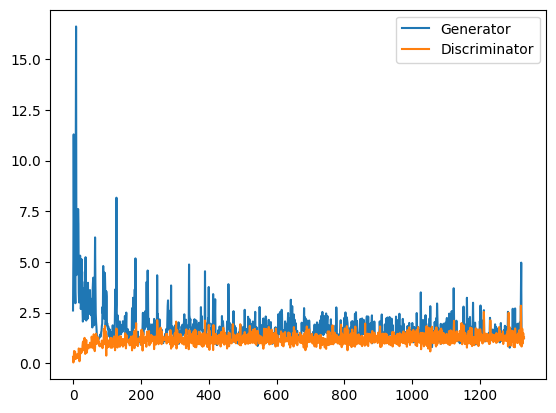

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time for epoch 1330 is 14.255068063735962 sec


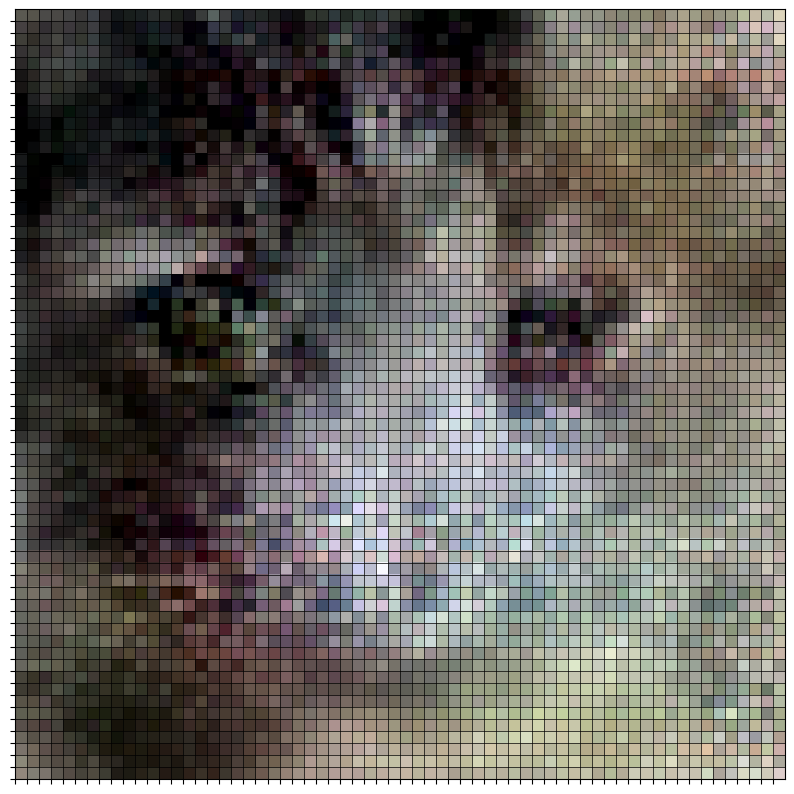

Epochs: 100%|██████████| 1330/1330 [6:00:15<00:00, 16.25s/it]


In [22]:
total_generator_loss = []
total_discriminator_loss = []

# Train
for epoch in tqdm(range(epochs), desc="Epochs"):
    # start timer
    start = time.time()
    generator_at_epoch_loss = 0
    discriminator_at_epoch_loss = 0 
    batch_count = 0
    
    for image_batch in tqdm(train_dataset, desc="Batches", leave=False):
        # generate random noise
        noise = tensorflow.random.normal([batch_size, noise_dim])
        real_image = image_batch

        # Record operations
        with tensorflow.GradientTape() as generator_tape, tensorflow.GradientTape() as discriminator_tape:  
            # create fake image
            random_image = generator(noise, training=True)
            
            # learn real image
            discriminate_real_image = discriminator(real_image, training=True)
            
            # learn fake image
            discriminate_random_image = discriminator(random_image, training=True)
            
            generator_loss_curr = generator_loss(discriminate_random_image)
            discriminator_loss_curr = discriminator_loss(discriminate_real_image, discriminate_random_image)
        
            generator_at_epoch_loss += generator_loss_curr
            discriminator_at_epoch_loss += discriminator_loss_curr
        # Gradients
        generator_gradient = generator_tape.gradient(generator_loss_curr, generator.trainable_variables)
        discriminator_gradient = discriminator_tape.gradient(discriminator_loss_curr, discriminator.trainable_variables)
        
        # Apply gradients
        generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
        
        batch_count += 1
        
    total_generator_loss.append(generator_at_epoch_loss/batch_count)
    total_discriminator_loss.append(discriminator_at_epoch_loss/batch_count)
    
    # clear output
    display.clear_output(wait=True)
    
    # plot losses
    plot_losses(total_generator_loss, total_discriminator_loss)
    
    
    with summary_writer.as_default(): 
      tensorflow.summary.scalar('Generator Loss', generator_loss_curr, step=epoch) 
      tensorflow.summary.scalar('Discriminator Loss', discriminator_loss_curr, step=epoch)
    
      
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(
        epoch + 1, time.time()-start))
        # # Print results
        # print('epoch: {}; generator_loss: {:.6f}; discriminator_loss: {:.6f}'.format(epoch+1, generator_loss_curr, discriminator_loss_curr))
        # # Plot generated images
        
    noise = tensorflow.random.normal([1, 100])
    image = generator(noise, training=False)
        # generated_image = generator(noise, training=False)
    display_pixel_image(64, image[0, :, :, :])
    # pyplot.imshow(image[0, :, :, :])
        
        # Save generated images 
        # seed_noise = tensorflow.random.normal([1, 100]) 
        # generated_image = generator(seed_noise, training=False) 
        # # Ensure generated_image is in a suitable format for saving 
        # generated_image = (generated_image[0] * 127.5 + 127.5).numpy().astype(numpy.uint8) 
        # # Save the image 
        # image_path = os.path.join(progress_folder, f'epoch_{epoch+1:03d}.png') 
        # pyplot.imsave(image_path, generated_image) 
        
        # Print results 
        # print(f'Epoch: {epoch+1}; Generator Loss: {generator_loss_curr:.6f}; Discriminator Loss: {discriminator_loss_curr:.6f}')

    # write log files on each batch  
    # summary_writer.flush()


In [23]:
b = generator.predict(seed)

1/1 [==============================] - 0s 403ms/step


In [24]:
b.shape

(16, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

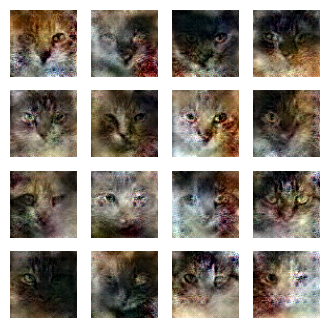

In [25]:
fig = pyplot.figure(figsize=(4, 4))

for i in range(b.shape[0]):
    pyplot.subplot(4, 4, i+1)
    pyplot.imshow(b[i])
    pyplot.axis('off')

pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


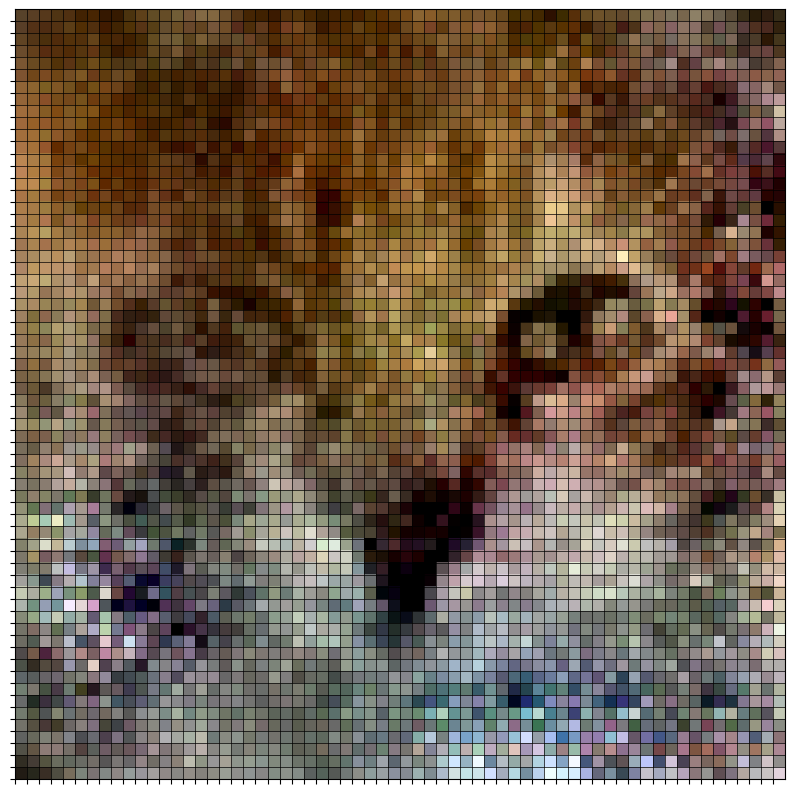

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


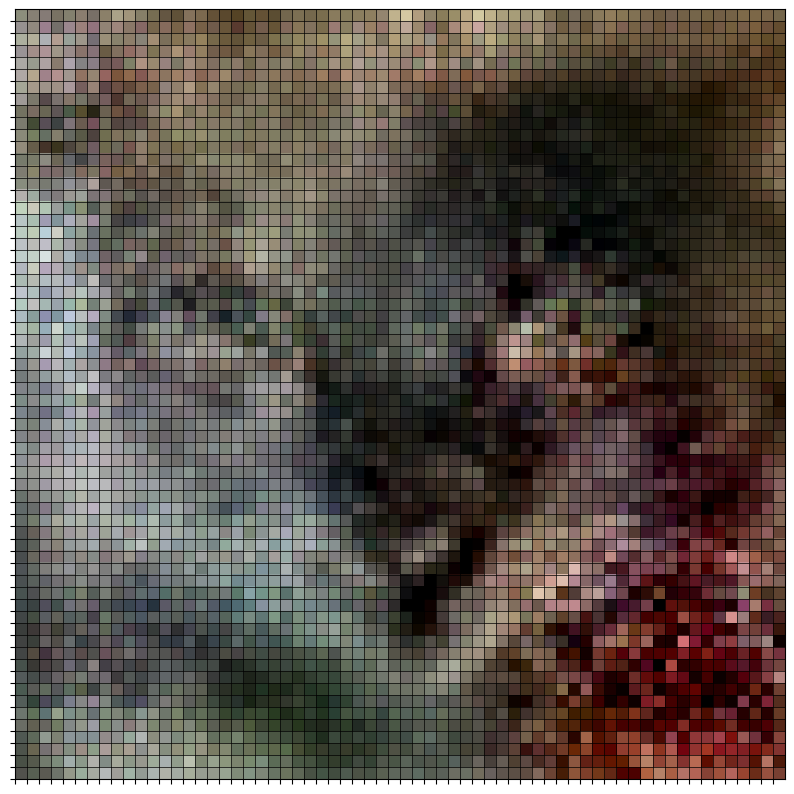

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


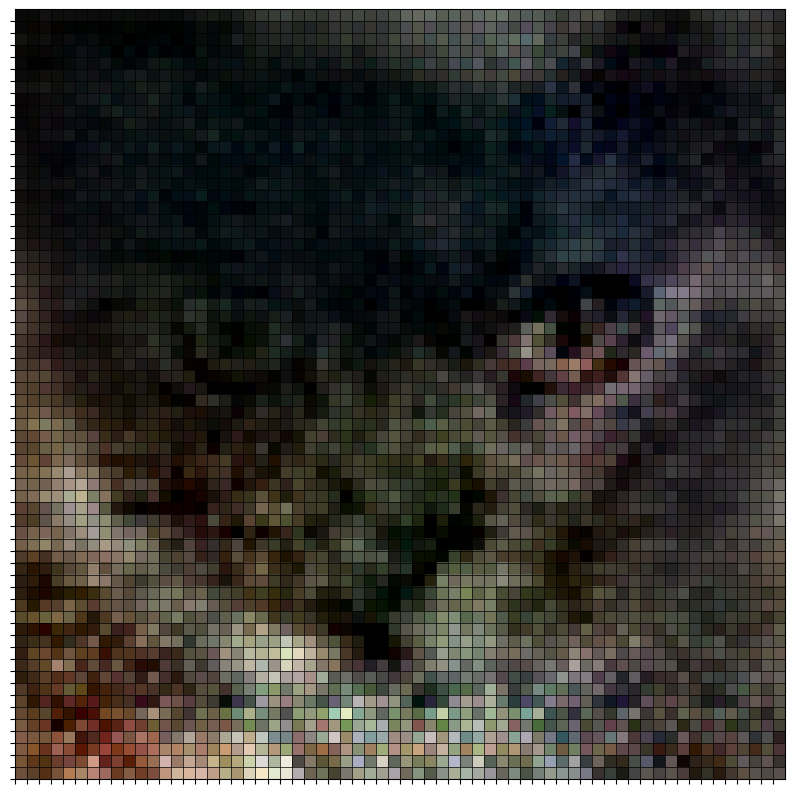

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


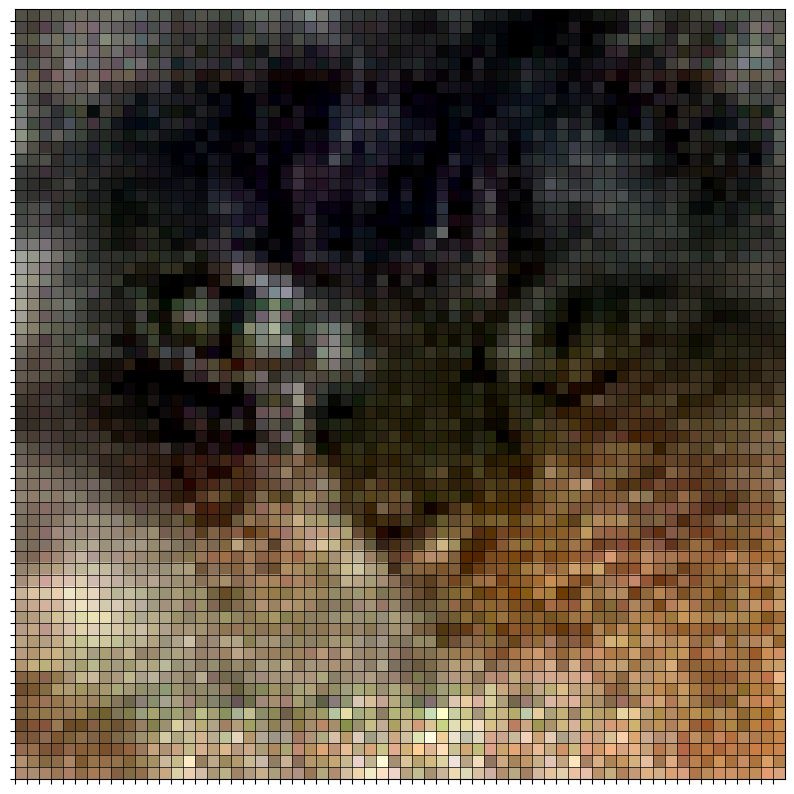

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


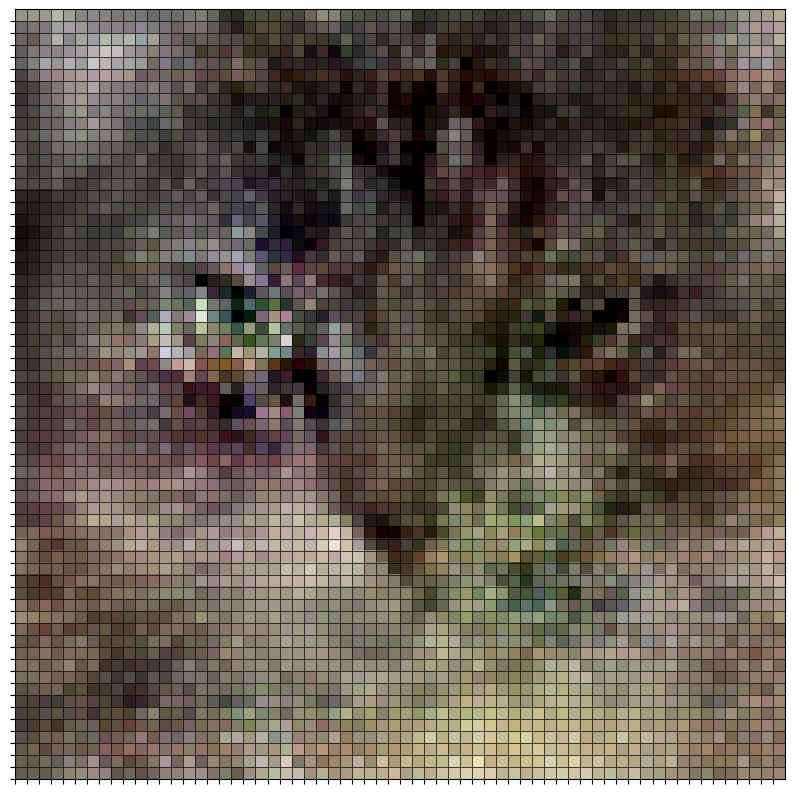

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


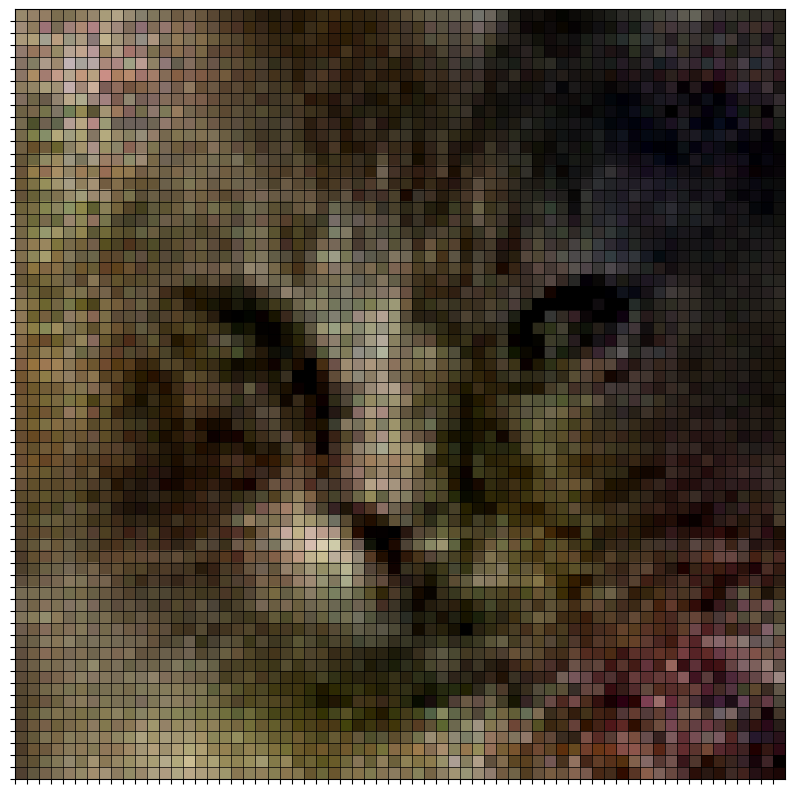

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


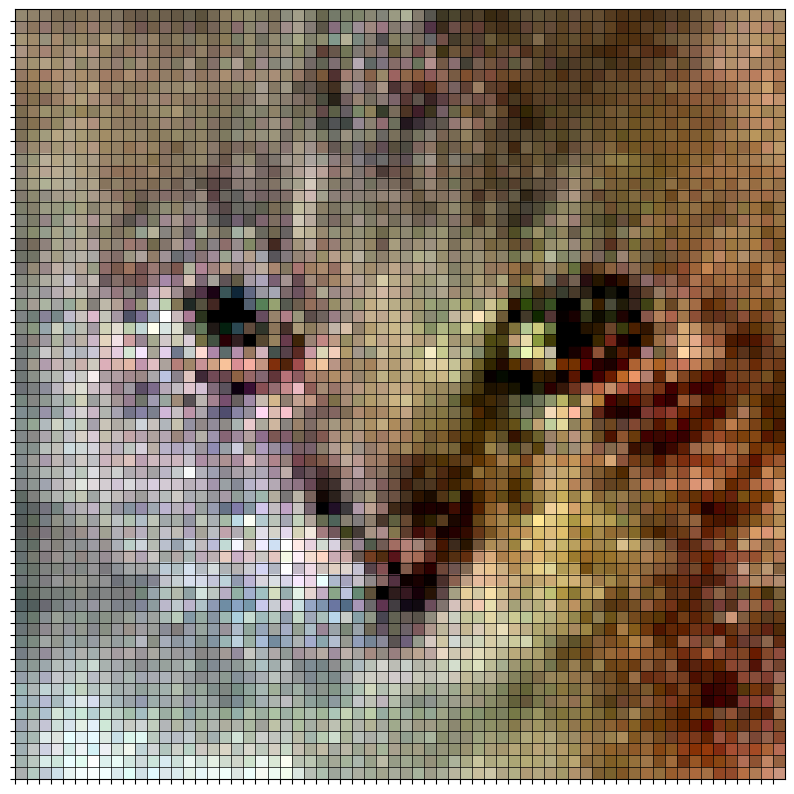

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


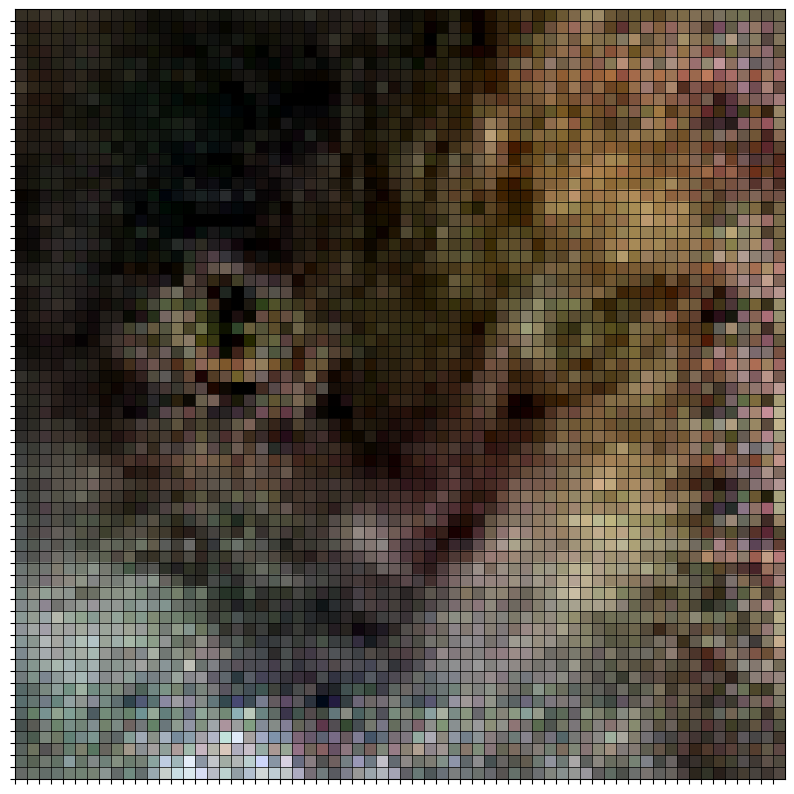

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


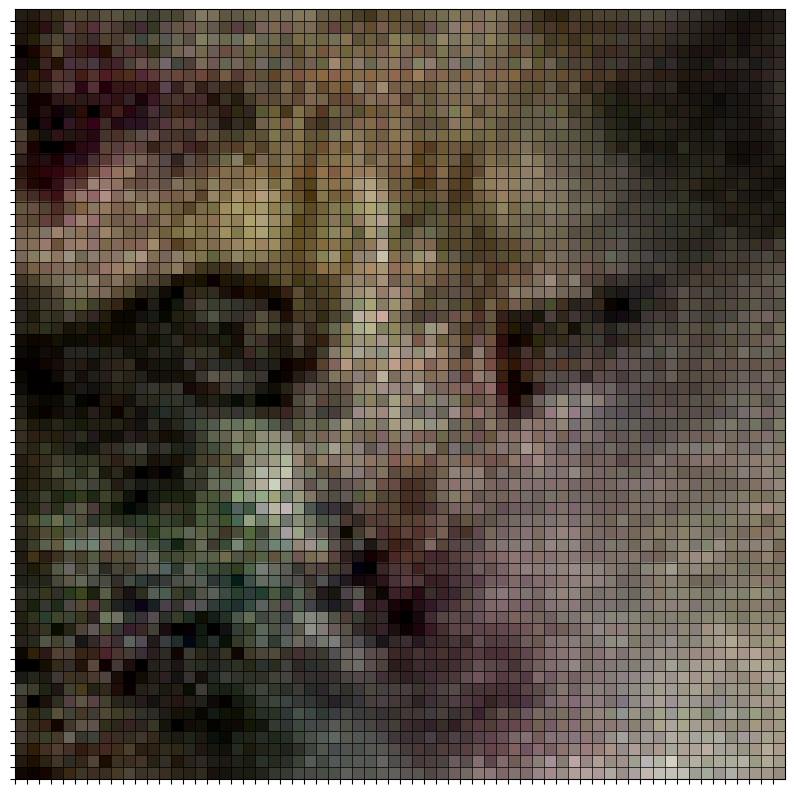

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


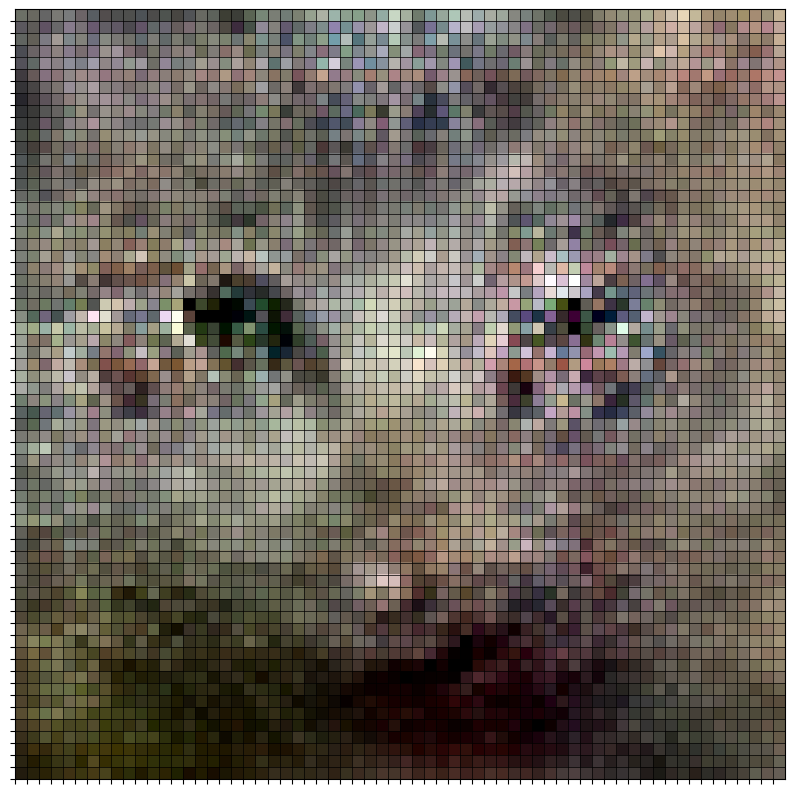

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


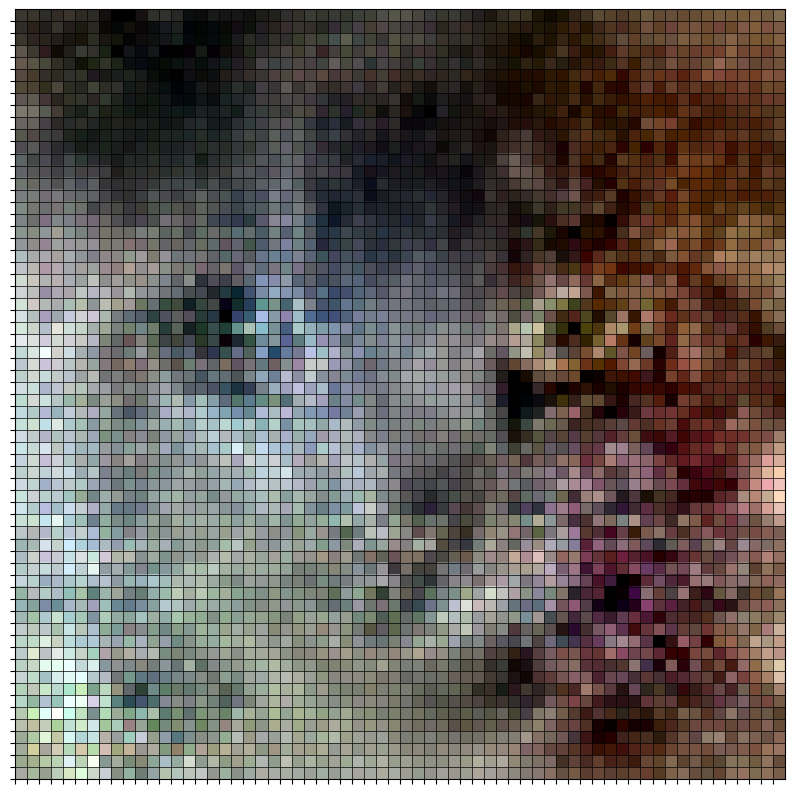

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


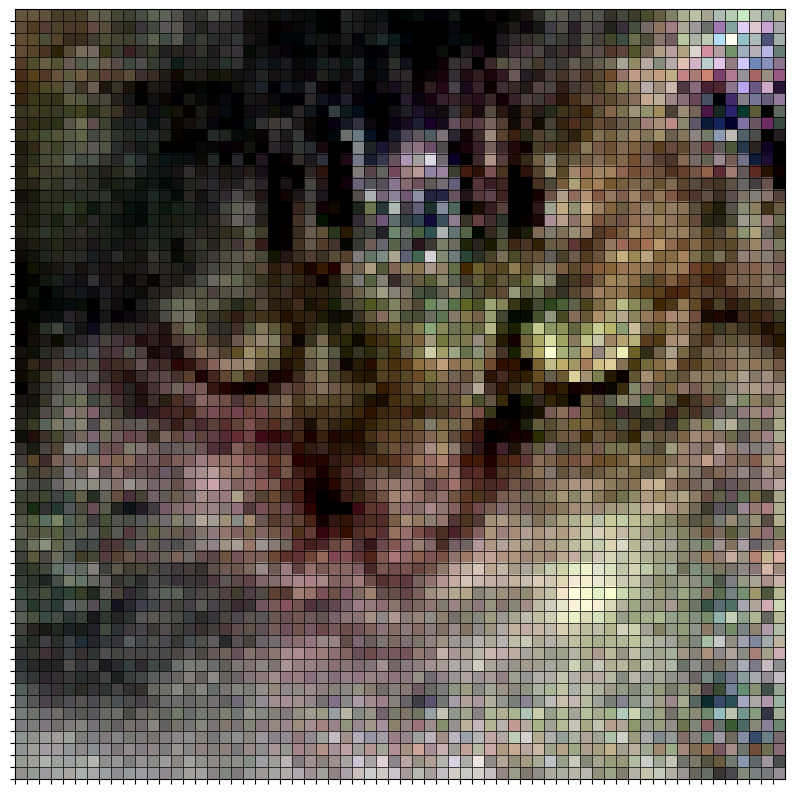

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


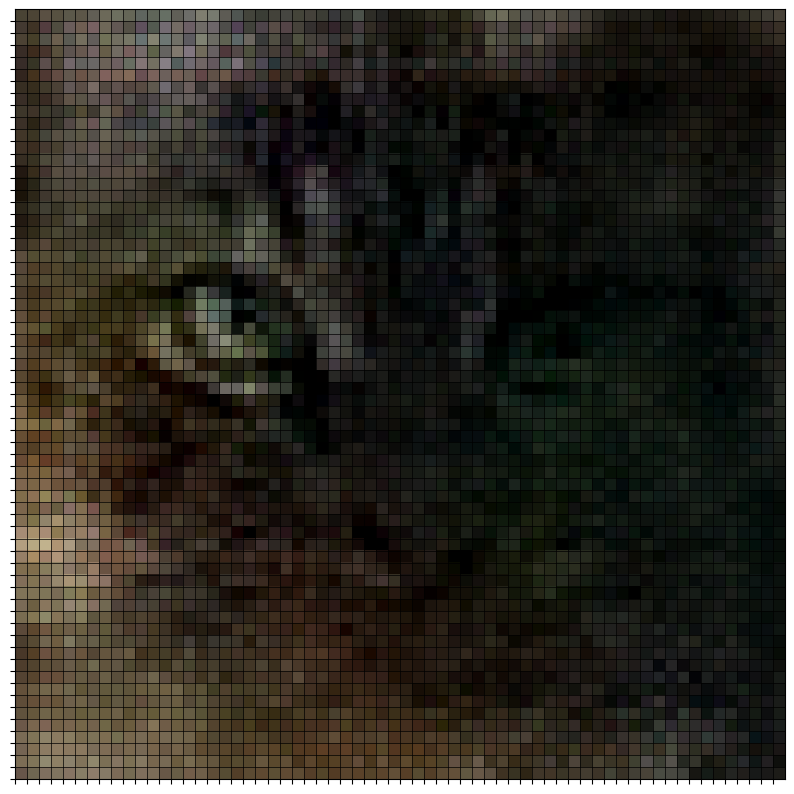

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


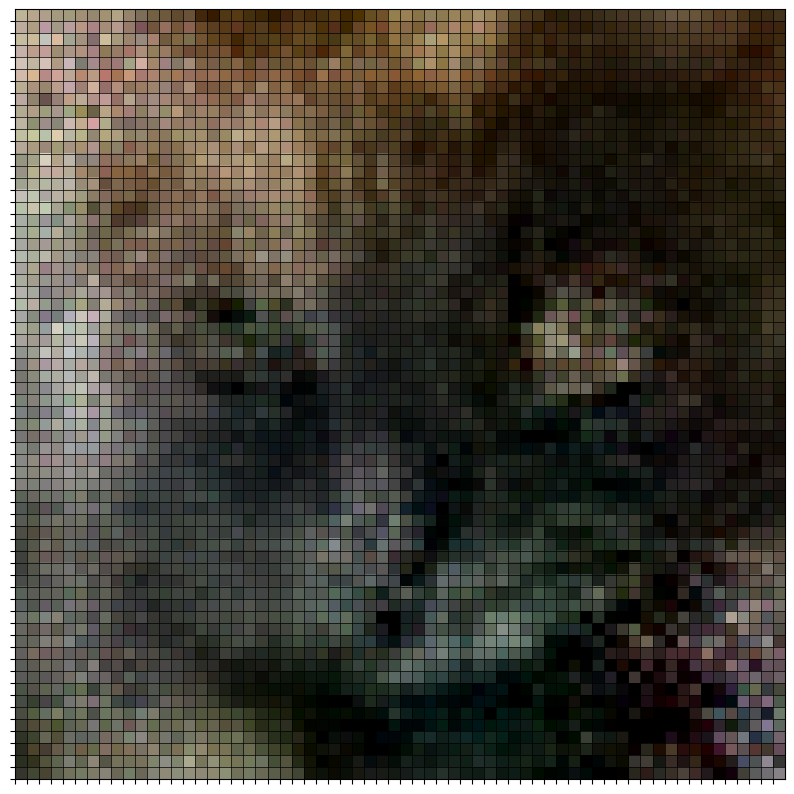

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


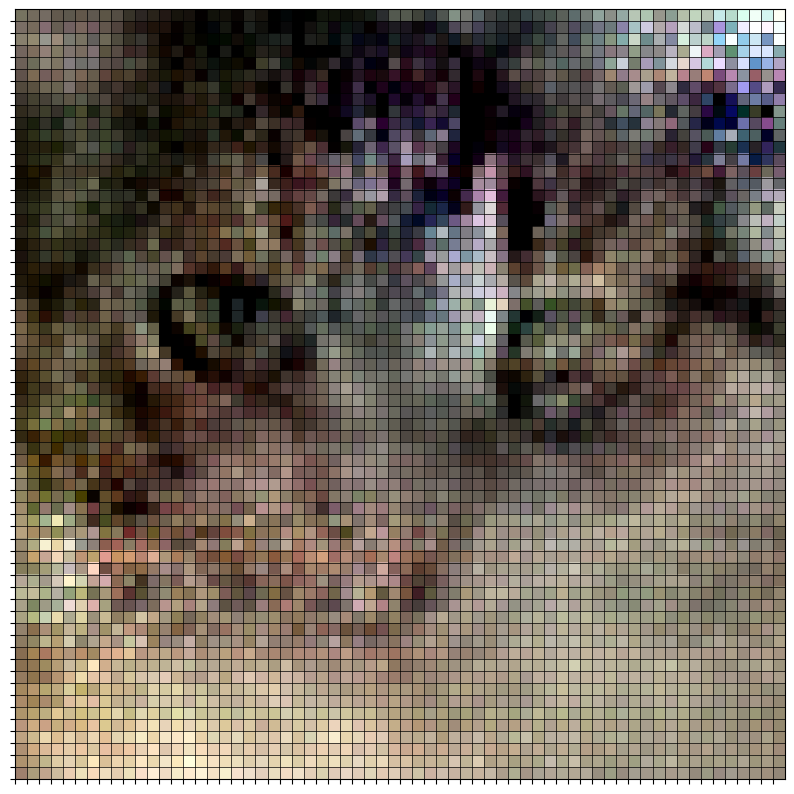

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


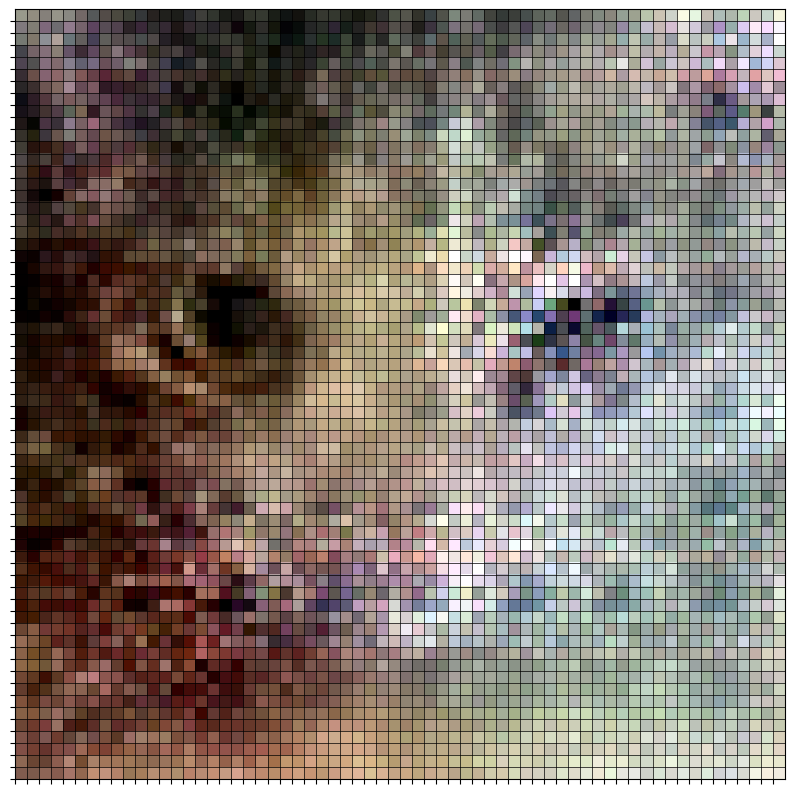

In [26]:
for i in range(b.shape[0]):
    display_pixel_image(b.shape[1], b[i, :, :, :])

In [27]:
generator.save('checkpoint/generator')
discriminator.save('checkpoint/discriminator')

INFO:tensorflow:Assets written to: checkpoint/generator\assets


INFO:tensorflow:Assets written to: checkpoint/generator\assets


INFO:tensorflow:Assets written to: checkpoint/discriminator\assets


INFO:tensorflow:Assets written to: checkpoint/discriminator\assets


In [2]:
loaded_generator = keras.models.load_model('checkpoint/generator')

In [6]:
current_time = int(time.time())
tensorflow.random.set_seed(current_time)
seed = tensorflow.random.normal([16, noise_dim])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


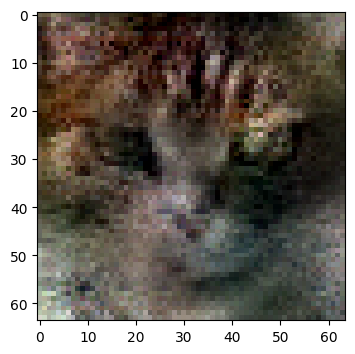

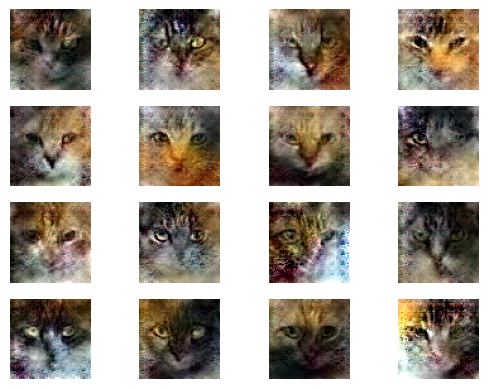

In [9]:
new_image = loaded_generator(seed, training=False)
fig = pyplot.figure(figsize=(4, 4))

pyplot.imshow(new_image[0, :, :, :])
pyplot.figure()
for i in range(new_image.shape[0]):
    pyplot.subplot(4, 4, i+1)
    image = new_image[i, :, :, :]
    pyplot.imshow(image)
    pyplot.axis('off')
    print(image.shape)

pyplot.show()